<a href="https://colab.research.google.com/github/Ryan-RE-Wang/MIMIC_Racial_Fairness_Project/blob/main/MIMIC_Racial_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import tensorflow as tf
import cv2 as cv
import gc
from enum import Enum
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
import itertools
warnings.filterwarnings("ignore")
 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/gdrive/My Drive/TFrecords/' /content/

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'
core:
  account: ryanwang@gapp.nthu.edu.tw

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you would like to use to perform operations for 
this configuration:
 [1] ryanwang@gapp.nthu.edu.tw
 [2] Log in with a new account
Please enter your numeric choice:  1

You are logged in as: [ryanwang@gapp.nthu.edu.tw].

Pick cloud project to use: 


In [ ]:
df_pa = pd.read_csv('/content/gdrive/MyDrive/patients.csv')
df_chexpert = pd.read_csv('/content/gdrive/Shared drives/MIMIC project/mimic-cxr-2.0.0-chexpert.csv')
df_ad = pd.read_csv('/content/gdrive/Shared drives/MIMIC project/admissions.csv')
df_meta = pd.read_csv('/content/gdrive/MyDrive/metadatas/metadata_fix.csv')

# Download Image from mimic_cxr




In [ ]:
df_missed = pd.read_csv('/content/gdrive/MyDrive/metadatas/mimic_cxr_missing.csv')
missed = df_missed['subject_id'].unique()

In [ ]:
!rm -rf downloads/
!rm -rf list_name.txt

In [ ]:
path = '/content/downloads/'

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

url = 'gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p'
f = open('list_name.txt',"w+")
for id in missed:
  source = '/content/gdrive/MyDrive/downloads/p'+(str(id))
  if (os.path.exists(source)):
    continue
  dir = url + str(id)[:2] + '/p' + str(id) + '/'
  f.write(dir)
  f.write('\n')
f.close()

Successfully created the directory /content/downloads/ 


In [ ]:
cat list_name.txt | gsutil -m cp -I -r ./downloads/

Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s50771383/2a280266-c8bae121-54d75383-cac046f4-ca37aa16.jpg...
Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s50771383/0c4eb1e1-b801903c-bcebe8a4-3da9cd3c-3b94a27c.jpg...
Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s54205396/8959e402-2175d68d-edba5a6c-baab51c3-9359f700.jpg...
Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s54205396/9e7a6aae-2580e589-6212d336-9813ebbd-a9239a34.jpg...
Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s54205396/b75df1bd-0f22d631-52d73526-2ae7b85a-d843b39d.jpg...
\ [5/5 files][  8.4 MiB/  8.4 MiB] 100% Done                                    
Operation completed over 5 objects/8.4 MiB.                                      


In [ ]:
from PIL import Image
import os

path = '/content/downloads/'
dirs = os.listdir(path)

for i in range(len(dirs)):
  subject_dirs = os.listdir( path + dirs[i] )
  for j in range(len(subject_dirs)):
    subject_dirs_items = os.listdir( path + dirs[i] + '/' + subject_dirs[j])
    for item in range(len(subject_dirs_items)):
      file_path = path + dirs[i] + '/' + subject_dirs[j] + '/' + subject_dirs_items[item]
      if os.path.isfile(file_path):
          im = Image.open(file_path)
          imResize = im.resize((256,256), Image.ANTIALIAS)
          imResize.save(file_path, 'JPEG', quality=90)
  id = dirs[i]
  print(id)
  !cp -r '/content/downloads/$id' '/content/gdrive/MyDrive/downloads'

p10000898


#Data Preprocess

In [ ]:
import os 

path = '/content/gdrive/Shared drives/MIMIC project/downloads/'

dirs = os.listdir(path)

In [ ]:
from PIL import Image
from numpy import asarray

x_train = []
count = 0

for i in range(len(dirs)):
    subject_dirs = os.listdir( path + dirs[i] )
    for j in range(len(subject_dirs)):
      subject_dirs_items = os.listdir( path + dirs[i] + '/' + subject_dirs[j])
      for item in range(len(subject_dirs_items)):
        file_path = path + dirs[i] + '/' + subject_dirs[j] + '/' + subject_dirs_items[item]
        x_train.append(asarray(Image.open(file_path)))
        count += 1
        print(count)

In [ ]:
print(np.array(x_train).shape)

In [ ]:
from PIL import Image
from numpy import asarray

image = Image.open(image_path[0])

data = asarray(image)

print(data)

[[  0   3   6 ...   0   0   0]
 [ 11   0   0 ...   0   0   0]
 [  0   3   1 ...   0   0   0]
 ...
 [240 240 241 ... 169 167 165]
 [241 241 242 ... 170 168 167]
 [241 241 242 ... 172 170 169]]


# TFRecord


In [ ]:
ls 'gdrive/Shared drives/MIMIC project/downloads/'

In [ ]:
import os
path = 'gdrive/Shareddrives/MIMIC project/downloads/'
dirs = os.listdir(path)
src = []
dicomId = []
count = 0
for i in range(len(dirs)):
    subject_dirs = os.listdir( path + dirs[i] )
    for j in range(len(subject_dirs)):
      subject_dirs_items = os.listdir( path + dirs[i] + '/' + subject_dirs[j])
      count += len(subject_dirs_items)
      print(count)
    #   for item in range(len(subject_dirs_items)):
    #     file_path = path + dirs[i] + '/' + subject_dirs[j] + '/' + subject_dirs_items[item]
    #     src.append(file_path)
    #     dicomId.append(item)
    #     print(count)
    #     count += 1


In [ ]:
print(count)

In [ ]:
import os 
path = '/content/gdrive/Shared drives/MIMIC project/downloads'

dirs = os.listdir(path)

metadata_fix = pd.DataFrame()

count = 0

for i in range(len(dirs)):
  id = int(dirs[i].replace('p', ''))
  metadata_fix = metadata_fix.append(df_meta.loc[df_meta['subject_id'] == id])
  # metadata_fix = df_meta.loc[df_meta['subject_id'] == id]
  count += len(metadata_fix)
  print(i, id)

In [ ]:
metadata_fix.to_csv('metadata_fix.csv')

In [ ]:
!cp -r 'PA_meta9.csv' '/content/gdrive/My Drive'

In [ ]:
def get_ethnicity(race):
  return {
      'WHITE':0,
      'BLACK/AFRICAN AMERICAN':1,
      'HISPANIC/LATINO':2,
      'OTHER':3,
      'ASIAN':4,
      'UNKNOWN':5,
      'UNABLE TO OBTAIN':6,
      'AMERICAN INDIAN/ALASKA NATIVE':7
  }.get(race, 5)

In [ ]:
import io
import tensorflow as tf
import numpy as np
import csv
import os 
import shutil
import pathlib
from PIL import Image
from PIL import ImageOps
import cv2 as cv
import pathlib
import os.path
from os import path

# record_iterator = tf.io.tf_record_iterator(path="tfrecords_valid_frontal-00000-of-00003.tfrecord")
# for string_record in record_iterator:
#     break

id_count = 0

record_file = '/content/gdrive/My Drive/TFrecords/mimic-tf-record15.tfrecords'

with tf.io.TFRecordWriter(record_file) as writer:
  with open('/content/gdrive/My Drive/metadatas/meta15.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    next(spamreader)

    for row in spamreader:    

      # print(row)
      # df = metadata.loc[metadata['dicom_id'] == row[0]]
        # if (row[0]['ViewPosition'] == 'PA' or row[0]['ViewPosition'] == 'AP'):
      df_of_row = df_chexpert.loc[df_chexpert['subject_id'] == int(float(row[2]))]# chexpert['study_id'] == int(row[2])]
      df_of_row = df_of_row.loc[df_of_row['study_id'] == int(float(row[3]))]
      df_of_row.reset_index(drop=True, inplace=True)
      # head_tail = os.path.split(row[0]) 
      # view = head_tail[1].replace('view', '').replace('_frontal', '').replace('_lateral', '')
      # head_tail = os.path.split(head_tail[0])
      subject = str(int(float(row[2])))
      # head_tail = os.path.split(head_tail[0])
      study = str(int(float(row[3])))
      dicom = row[1]

      if (df_of_row.empty):
        print('qaq')
        continue
      
      example = tf.train.Example()
      # example.ParseFromString(string_record)
      # p = pathlib.PureWindowsPath(row[0])                
          
      source = '/content/gdrive/Shared drives/MIMIC project/downloads' + '/p' + subject + '/s' + study + '/' + dicom+ '.jpg'
      
      """
      with open(source, 'rb') as fd:
          imgByteArr=fd.read()
            #from Byte to Img
          imageStream = io.BytesIO(imgByteArr)
          imageOrigin = Image.open(imageStream)
          Replace your function here
          newsize = (320, 320) 
          img = imageOrigin.resize(newsize)            
            #from Img to Byte
          imgByteArr = io.BytesIO()
          img.save(imgByteArr, format='JPEG')
          imgByteArr = imgByteArr.getvalue() 
      """   
      # newsize = (320, 320)
      if (not path.exists(source)):
        continue
      img = Image.open(source)

      img = img.resize((256,256), Image.ANTIALIAS)

      img = ImageOps.equalize(img)
      imgByteArr = io.BytesIO()
      img.save(imgByteArr, format='JPEG')
      imgByteArr = imgByteArr.getvalue()

      race = df_data[df_data['subject_id'] == int(subject)]['ethnicity'].values

      ethnicity = get_ethnicity(str(race[0]))

      # ethnicity_count[ethnicity] += 1

      # success, encoded_image = cv.imencode('.jpg', img)
      # imgByteArr = encoded_image.tobytes()                                                   
      
      # 1.0 0.0 -1.0 nan
      # df_of_row = df_of_row.replace({1: int(3), 0: int(2), -1: int(1), np.nan: int(0)})
      # print(df_of_row)
          # Put it back to tf_record
      example.features.feature['jpg_bytes'].bytes_list.value.append(imgByteArr)  
      example.features.feature['Atelectasis'].float_list.value.append(df_of_row['Atelectasis'][0])
      example.features.feature['Cardiomegaly'].float_list.value.append(df_of_row['Cardiomegaly'][0])
      example.features.feature['Consolidation'].float_list.value.append(df_of_row['Consolidation'])
      example.features.feature['Edema'].float_list.value.append(df_of_row['Edema'][0])
      example.features.feature['Enlarged Cardiomediastinum'].float_list.value.append(df_of_row['Enlarged Cardiomediastinum'][0])
      example.features.feature['Fracture'].float_list.value.append(df_of_row['Fracture'][0])
      example.features.feature['Lung Lesion'].float_list.value.append(df_of_row['Lung Lesion'][0])
      example.features.feature['Lung Opacity'].float_list.value.append(df_of_row['Lung Opacity'][0])
      example.features.feature['No Finding'].float_list.value.append(df_of_row['No Finding'][0])
      example.features.feature['Pleural Effusion'].float_list.value.append(df_of_row['Pleural Effusion'][0])
      example.features.feature['Pleural Other'].float_list.value.append(df_of_row['Pleural Other'][0])
      example.features.feature['Pneumonia'].float_list.value.append(df_of_row['Pneumonia'][0])
      example.features.feature['Pneumothorax'].float_list.value.append(df_of_row['Pneumothorax'][0])
      example.features.feature['Support Devices'].float_list.value.append(df_of_row['Support Devices'][0])

      example.features.feature['subject_id'].int64_list.value.append(int(subject))
      example.features.feature['study_id'].int64_list.value.append(int(study))
      example.features.feature['ethnicity'].int64_list.value.append(ethnicity)
      # example.features.feature['dicom_id'].int64_list.value[0] = int(view[:-4])
      # print(example)
      writer.write(example.SerializeToString())

      print(id_count, img.size)
      id_count += 1
      if (img.size != (256,256)):
        break

# Statistic

In [ ]:
path = '/content/gdrive/MyDrive/Racial_project_result/ethnicity_age_ratio.csv'
result_ = pd.read_csv(path, index_col=0)
result_

,-20,20-40,40-60,60-80,80-
index,,,,,
WHITE,0.512146,0.505297,0.606634,0.695301,0.755919
BLACK/AFRICAN AMERICAN,0.154858,0.217172,0.192003,0.143221,0.095538
HISPANIC/LATINO,0.084008,0.109017,0.072142,0.039671,0.022284
OTHER,0.053644,0.060688,0.051991,0.043656,0.035890
ASIAN,0.073887,0.035887,0.028754,0.033016,0.033882
UNKNOWN,0.109312,0.064753,0.039958,0.038325,0.050996
UNABLE TO OBTAIN,0.008097,0.005995,0.004016,0.004316,0.003696
AMERICAN INDIAN/ALASKA NATIVE,0.004049,0.001191,0.004502,0.002494,0.001795


In [ ]:
result_ratio.to_csv(path)

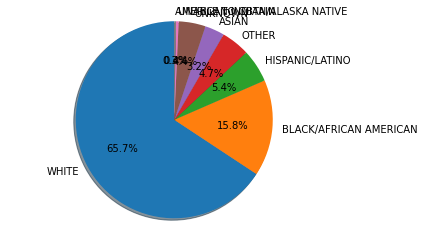

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(result_[''], labels=ethinicity_, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
gender_list = ['M', 'F']
age_range = [0, 20, 40, 60, 80]
ethinicity_ = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN', 'UNKNOWN', 'UNABLE TO OBTAIN', 'AMERICAN INDIAN/ALASKA NATIVE']
Labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

In [ ]:
def get_ethnicity(race):
  return {
      'WHITE':0,
      'BLACK/AFRICAN AMERICAN':1,
      'HISPANIC/LATINO':2,
      'OTHER':3,
      'ASIAN':4,
      'UNKNOWN':5,
      'UNABLE TO OBTAIN':6,
      'AMERICAN INDIAN/ALASKA NATIVE':7
  }.get(race, 5)

In [ ]:
# ethnicity_count = [0 for i in range(24)]

# for i in range(24):
#     ethnicity_count[i] = [0 for j in range(8)]

image_count = 0
asia_count = 0
latino_count = 0
white_count = 0
black_count = 0

# list_0 = [0, 2, 3, 8, 20, 15]
# list_1 = [6, 7, 12, 17, 18, 22]
# list_2 = [16, 13, 14, 4, 9, 21]
# list_3 = [23, 10, 5]
# list_test = [1, 11, 19]

table_1 = pd.DataFrame()

for i in range(24):

    print('loading file:', i)
    filename = '/content/TFrecords/mimic-tf-record{i}.tfrecords'.format(i=i)
    raw_dataset = tf.data.TFRecordDataset(filename)

    for raw_record in raw_dataset:
        
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
 
        ethnicity = example.features.feature['ethnicity'].int64_list.value[0]
        id = example.features.feature['subject_id'].int64_list.value[0]
        gender = df_pa.loc[df_pa['subject_id'] == id, 'gender'].values
        age = df_pa.loc[df_pa['subject_id'] == id, 'anchor_age'].values

        Atelectasis = (1 if example.features.feature['Atelectasis'].float_list.value[0] == 1 else 0)
        Cardiomegaly = (1 if example.features.feature['Cardiomegaly'].float_list.value[0] == 1 else 0)
        Consolidation = (1 if example.features.feature['Consolidation'].float_list.value[0] == 1 else 0)
        Edema = (1 if example.features.feature['Edema'].float_list.value[0] == 1 else 0)
        Cardiomediastinum = (1 if example.features.feature['Enlarged Cardiomediastinum'].float_list.value[0] == 1 else 0)
        Fracture = (1 if example.features.feature['Fracture'].float_list.value[0] == 1 else 0)
        Lesion = (1 if example.features.feature['Lung Lesion'].float_list.value[0] == 1 else 0)
        Opacity = (1 if example.features.feature['Lung Opacity'].float_list.value[0] == 1 else 0)
        Finding = (1 if example.features.feature['No Finding'].float_list.value[0] == 1 else 0)
        Effusion = (1 if example.features.feature['Pleural Effusion'].float_list.value[0] == 1 else 0)
        Other = (1 if example.features.feature['Pleural Other'].float_list.value[0] == 1 else 0)
        Pneumonia = (1 if example.features.feature['Pneumonia'].float_list.value[0] == 1 else 0)
        Pneumothorax = (1 if example.features.feature['Pneumothorax'].float_list.value[0] == 1 else 0)
        Devices = (1 if example.features.feature['Support Devices'].float_list.value[0] == 1 else 0)

        row = pd.DataFrame({'Id':image_count, 'Race':ethinicity_[ethnicity], 'Gender':gender, 'Age':age, 'Atelectasis':Atelectasis, 'Cardiomegaly':Cardiomegaly, 'Consolidation':Consolidation, 'Edema':Edema,
                            'Enlarged Cardiomediastinum':Cardiomediastinum, 'Fracture':Fracture, 'Lung Lesion':Lesion, 'Lung Opacity':Opacity, 'No finding':Finding, 
                            'Pleural Effusion':Effusion, 'Pleural Other':Other, 'Pneumonia':Pneumonia, 'Pneumothorax':Pneumothorax, 'Support Devices':Devices})
        
        table_1 = table_1.append(row)
        
        # ethnicity_count[i][ethnicity] += 1
        # if (ethnicity == 2):
        #     latino_count += 1
        # elif (ethnicity == 4):
        #     asia_count += 1
        # if (ethnicity == 0):
        #     white_count += 1
        # elif (ethnicity == 1):
        #     black_count += 1
        # else:
        #     continue
            
        image_count += 1
 
    # print('\n', filename, 'distribution')
    # for j in range(len(ethnicity_)):
    #   print(ethnicity_[j], ':', ethnicity_count_[j])
 
# print('\nOverall distribution')
# print('ethnicity in record:')
# for j in range(len(ethnicity_)):
#     print(ethnicity_[j], ':', ethnicity_count[j]/image_count)

# distribution = pd.DataFrame()
# for i in range(8):
#     distribution[Labels[i]] = count[i]

     
# print('total images:', image_count)
# print('white:', white_count/image_count)
# print('black:', black_count/image_count)
# print('latino:', latino_count/image_count)
# print('asia:', asia_count/image_count)

loading file: 0
loading file: 1
loading file: 2
loading file: 3
loading file: 4
loading file: 5
loading file: 6
loading file: 7
loading file: 8
loading file: 9
loading file: 10
loading file: 11
loading file: 12
loading file: 13
loading file: 14
loading file: 15
loading file: 16
loading file: 17
loading file: 18
loading file: 19
loading file: 20
loading file: 21
loading file: 22
loading file: 23


In [ ]:
pip install tableone

In [ ]:
from tableone import TableOne

table_1 = table_1.set_index(['Id'])

columns = ['Race', 'Gender', 'Age']

categorical = ['Race', 'Gender']

nonnormal = ['Age']

mytable = TableOne(table_1, columns=columns, categorical=categorical)

In [ ]:
print(mytable.tabulate(tablefmt="latex"))
print(mytable.tabulate(tablefmt="html"))
print(mytable.tabulate(tablefmt="fancy_grid"))
print(mytable.tabulate(tablefmt="rst"))

\begin{tabular}{llll}
\hline
                &                               & Missing   & Overall       \\
\hline
 n              &                               &           & 229271        \\
 Race, n (\%)    & AMERICAN INDIAN/ALASKA NATIVE & 0         & 656 (0.3)     \\
                & ASIAN                         &           & 7414 (3.2)    \\
                & BLACK/AFRICAN AMERICAN        &           & 36282 (15.8)  \\
                & HISPANIC/LATINO               &           & 12451 (5.4)   \\
                & OTHER                         &           & 10727 (4.7)   \\
                & UNABLE TO OBTAIN              &           & 990 (0.4)     \\
                & UNKNOWN                       &           & 10088 (4.4)   \\
                & WHITE                         &           & 150663 (65.7) \\
 Gender, n (\%)  & F                             & 0         & 105147 (45.9) \\
                & M                             &           & 124124 (54.1) \\
 Age, mean (SD

In [ ]:
mytable.to_excel('mytable.xlsx')

In [ ]:
total_ethinicity = [0 for i in range(8)]

for i in range(24):
    print('\nfile', i, ':')
    for j in range(8):
        print(ethinicity_[j], ':', ethinicity_count[i][j]/np.sum(ethinicity_count[i]))
        total_ethinicity[j] += ethinicity_count[i][j]

print('\ntotal distribution:')
for i in range(8):
    print(ethinicity_[i], ':', total_ethinicity[i]/np.sum(total_ethinicity))

In [ ]:
test = [0 for i in range(8)]
for i in [1, 11, 19]:
    for j in range(8):
        test[j] += ethinicity_count[i][j]

for i in range(8):
    print(ethinicity_[i], ':', test[i]) 

WHITE : 19552
BLACK/AFRICAN AMERICAN : 4050
HISPANIC/LATINO : 1288
OTHER : 1422
ASIAN : 1112
UNKNOWN : 866
UNABLE TO OBTAIN : 137
AMERICAN INDIAN/ALASKA NATIVE : 93


In [ ]:
distribution_H_age = pd.DataFrame()

distribution_H_age['Hispanic_0-20'] = W_age_count[0]
distribution_H_age['Hispanic_20-40'] = W_age_count[1]
distribution_H_age['Hispanic_40-60'] = W_age_count[2]
distribution_H_age['Hispanic_60-80'] = W_age_count[3]
distribution_H_age['Hispanic_80-'] = W_age_count[4]
distribution_H_age['diseases'] = Labels
distribution_H_age.set_index('diseases', inplace=True)

In [ ]:
distribution_H_gender = pd.DataFrame()

distribution_H_gender['Hispanic_Male'] = W_gender_count[0]
distribution_H_gender['Hispanic_FeMale'] = W_gender_count[1]

distribution_H_gender['diseases'] = Labels
distribution_H_gender.set_index('diseases', inplace=True)

In [ ]:
distribution_age_ratio = pd.concat([distribution_H_age, distribution_A_age], axis=1) 
distribution_gender_ratio = pd.concat([distribution_H_gender, distribution_A_gender], axis=1) 

In [ ]:
for i, r in distribution_age_ratio.iterrows():
    total = r.sum()
    distribution_age_ratio.loc[i] /= total

In [ ]:
path = '/content/gdrive/MyDrive/Racial_project_result/Hispanic_Asia_gender_ratio.csv'

distribution_gender_ratio.to_csv(path)

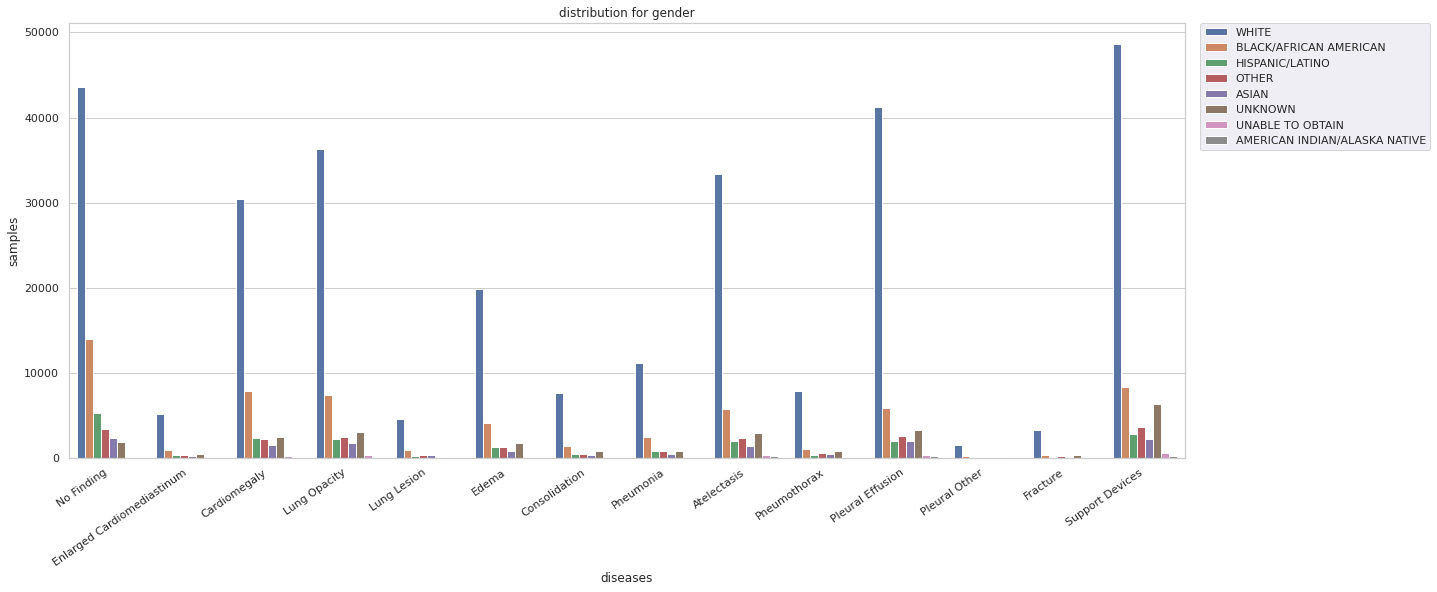

In [ ]:
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")


sns.set(style="whitegrid")
sns.barplot(x='diseases', y='samples', hue='ethinicity', data=result_, ax=ax).set_title('distribution for gender')
sns.set(font_scale=1)

h, l = ax.get_legend_handles_labels()
# counts = {'WHITE':1438, 'BLACK/AFRICAN AMERICAN':1438}
# l = [f'{yn} (n={c})' for yn,c in counts.items()]
ax.legend(h,l, loc='upper right', bbox_to_anchor=(1.22, 1), borderaxespad=0.)


In [ ]:
distribution.to_csv('/content/gdrive/MyDrive/Racial_project_result/ethnicity_symptoms_ratio.csv')

In [ ]:
for j in range(len(ethnicity_)):
  print(ethnicity_[j], ':', ethnicity_count[j])

WHITE : 70166
BLACK/AFRICAN AMERICAN : 14371
HISPANIC/LATINO : 3983
OTHER : 4326
ASIAN : 3376
UNKNOWN : 3870
UNABLE TO OBTAIN : 427
AMERICAN INDIAN/ALASKA NATIVE : 243


# Densenet121 use np.array

model for classify 14 labels

customize loss to **minimize** the loss of predicting 14 disease and **maximize** the losss of classify race meanwile

In [ ]:
def disease_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    return bce(y_true, y_pred)

def race_loss(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    return 1/cce(y_true, y_pred)

losses = {
    
	"pred_disease": disease_loss,
	"clf_race": race_loss,
}

lossWeights_d= {"pred_disease": 1, "clf_race": 10}
lossWeights_r = {"pred_disease": 1, "clf_race": 1000}

In [ ]:
def define_model():
    INPUT_HWC = (256, 256, 1)
    base_model = tf.keras.applications.densenet.DenseNet121(
            include_top=False, weights=None, input_shape=INPUT_HWC, pooling='max')
 
    x = tf.keras.layers.Dropout(0.5)(base_model.output)
 
    pred_disease = tf.keras.layers.Dense(14, activation='sigmoid', name='pred_disease')(x)
 
    clf_race = tf.keras.layers.Dense(2, activation='softmax', name='clf_race')(x)
 
    # model = tf.keras.Model(inputs=base_model.input, outputs=[pred_disease, clf_race])
    model = tf.keras.Model(inputs=base_model.input, outputs=clf_race)

 
    print(model.summary())
 
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy())

    return model
 
model = define_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
list_0 = [3, 2, 0, 8, 10, 23]
list_1 = [7, 22, 4, 15, 18]
list_2 = [16, 13, 14, 5, 6]
list_3 = [12, 17, 9, 20, 21]
epochs = 10

for num in range(epochs):
    # if (num % 3 == 0):
    #     model.get_layer(name='pred_disease').trainable = False
    #     model.get_layer(name='clf_race').trainable = True
    #     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=losses, loss_weights=lossWeights_r)
    #     model.summary()
    # else:
    #     model.get_layer(name='pred_disease').trainable = True
    #     model.get_layer(name='clf_race').trainable = False
    #     model.compile(optimizer=tf.keras.optimizers.Adam(), loss=losses, loss_weights=lossWeights_d)
    #     model.summary()

    for i in range(4):

        if (i == 0):
            files = list_0
        elif (i == 1):
            files = list_1
        elif (i == 2):
            files = list_2
        else :
            files = list_3

        X_train = []
        # y_train_d = []
        y_train_r = []

        for j in files:

            print('epoch:', num, 'now is loading file', j)
            filename = '/content/TFrecords/mimic-tf-record{j}.tfrecords'.format(j=j)
            raw_dataset = tf.data.TFRecordDataset(filename)
            
            for raw_record in raw_dataset:
                sub_y = []
                sub_y_r = []
            
                example = tf.train.Example()
                example.ParseFromString(raw_record.numpy())
                ethnicity = example.features.feature['ethnicity'].int64_list.value[0]

                if (ethnicity == 0):
                    sub_y_r = [1, 0]
                elif (ethnicity == 1):
                    sub_y_r = [0, 1]
                # elif (ethnicity == 2):
                #     sub_y_r = [0, 0, 1, 0]
                # elif (ethnicity == 4):
                #     sub_y_r = [0, 0, 0, 1]
                else: 
                    continue

                # sub_y.append(1 if example.features.feature['Atelectasis'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Cardiomegaly'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Consolidation'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Edema'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Enlarged Cardiomediastinum'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Fracture'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Lung Lesion'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Lung Opacity'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['No Finding'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Pleural Effusion'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Pleural Other'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Pneumonia'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Pneumothorax'].float_list.value[0] == 1 else 0)
                # sub_y.append(1 if example.features.feature['Support Devices'].float_list.value[0] == 1 else 0)

                nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
                img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)

                img_np = img_np/256
                img_np = np.float16(img_np)

                X_train.append(img_np)
                # y_train_d.append(sub_y)
                y_train_r.append(sub_y_r)

                # del sub_y
                del sub_y_r
                del img_np
        
        X_train = np.array(X_train)
        # y_train_d = np.array(y_train_d)
        y_train_r = np.array(y_train_r)

        print(X_train.shape)
    
        # model.fit(x=X_train, y={'pred_disease':y_train_d, 'clf_race':y_train_r}, batch_size=32, epochs=1, shuffle=True)
        model.fit(x=X_train, y=y_train_r, batch_size=32, epochs=1, shuffle=True)

        del X_train
        # del y_train_d
        del y_train_r

        gc.collect()

model.save('gdrive/MyDrive/saved_model/cxr_model_race_clf_bw')

epoch: 0 now is loading file 3
epoch: 0 now is loading file 2
epoch: 0 now is loading file 0
epoch: 0 now is loading file 8
epoch: 0 now is loading file 10
epoch: 0 now is loading file 23
(47772, 256, 256)
1493/1493 [==============================] - 219s 137ms/step - loss: 0.6475
epoch: 0 now is loading file 7
epoch: 0 now is loading file 22
epoch: 0 now is loading file 4
epoch: 0 now is loading file 15
epoch: 0 now is loading file 18
(37326, 256, 256)
1167/1167 [==============================] - 159s 137ms/step - loss: 0.7121
epoch: 0 now is loading file 16
epoch: 0 now is loading file 13
epoch: 0 now is loading file 14
epoch: 0 now is loading file 5
epoch: 0 now is loading file 6
(40830, 256, 256)
1276/1276 [==============================] - 175s 137ms/step - loss: 0.3609
epoch: 0 now is loading file 12
epoch: 0 now is loading file 17
epoch: 0 now is loading file 9
epoch: 0 now is loading file 20
epoch: 0 now is loading file 21
(37415, 256, 256)
1170/1170 [==========================

In [ ]:
gc.collect()

642892

INFO:tensorflow:Assets written to: gdrive/MyDrive/saved_model/cxr_model_two_step_optimize/assets
testing WHITE
WHITE has 19552 images
testing BLACK/AFRICAN AMERICAN
BLACK/AFRICAN AMERICAN has 4050 images
testing HISPANIC/LATINO
HISPANIC/LATINO has 1288 images
testing ASIAN
ASIAN has 1422 images


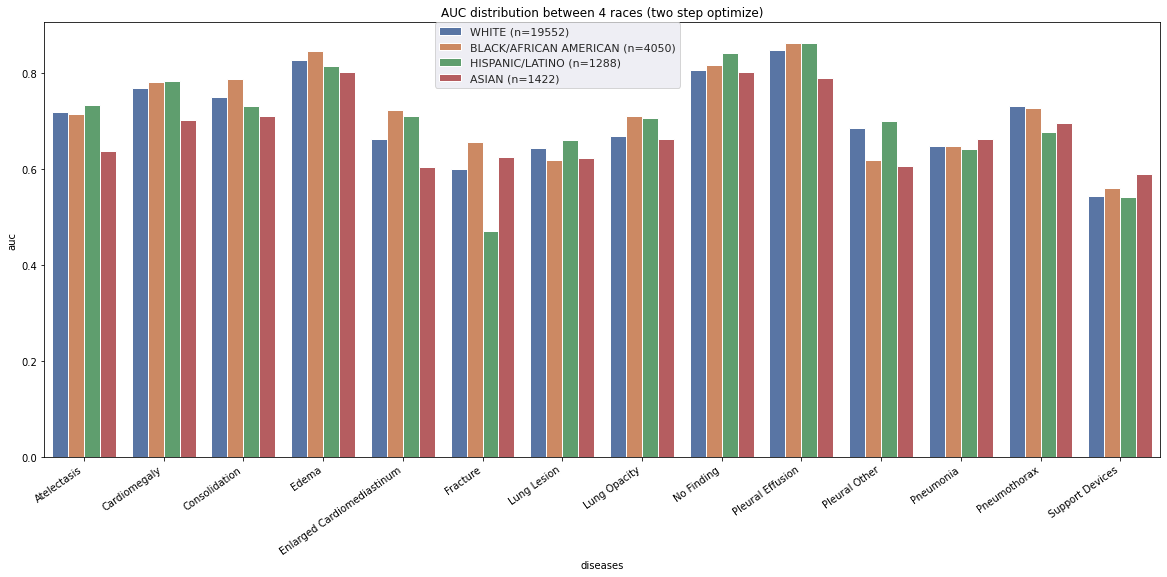

In [ ]:
# test_draw_bar_plot(model, 'AUC distribution between 4 races (two step optimize)')

## Use CNN feature to classify race

### get_data_from_pretrained_model

In [ ]:
def get_data_from_pretrained_model():

    # base_model = tf.keras.models.load_model('/content/gdrive/MyDrive/saved_model/cxr_model_with_two_step_optimize')
    # new_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=base_model.get_layer('max_pool').output)
    # new_model.trainable = False

    new_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer('max_pool').output)
    new_model.trainable = False

    X_train_ = []
    X_test_ = []
    y_train = []
    y_test = []
    
    for i in range(24):
    
        print('now is loading file', i)
        filename = '/content/gdrive/My Drive/TFrecords/mimic-tf-record{i}.tfrecords'.format(i=i)
        raw_dataset = tf.data.TFRecordDataset(filename)
        
        X = []
        y = []
        for raw_record in raw_dataset:
            sub_y = []
        
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            ethnicity = example.features.feature['ethnicity'].int64_list.value[0]
    
            if (ethnicity == 0):
                sub_y = [1, 0, 0, 0]
    
            elif (ethnicity == 1):
                sub_y = [0, 1, 0, 0]
            
            elif (ethnicity == 2):
                sub_y = [0, 0, 1, 0]
            elif (ethnicity == 4):
                sub_y = [0, 0, 0, 1]
    
            else: 
                continue
    
            nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
            img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
    
            img_np = img_np/256
            img_np = np.float16(img_np)
    
            X.append(img_np)
    
            if (i == 1 or i == 11 or i == 19):
                y_test.append(sub_y)
            else:
                y_train.append(sub_y)
    
        
        if (i == 1 or i == 11 or i == 19):
            feature = new_model.predict(np.array(X))
            X_test_.append(feature)
        else:
            feature = new_model.predict(np.array(X))
            X_train_.append(feature)
            
        del X
        del y
        gc.collect()
    
    X_train = X_train_[0]
    for i in range(1, 21):
        X_train = np.append(X_train, X_train_[i], axis=0)
    
    del X_train_
    
    X_test = X_test_[0]
    for i in range(1, 3):
        X_test = np.append(X_test, X_test_[i], axis=0)
    
    del X_test_

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    gc.collect()
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = get_data_from_pretrained_model()

now is loading file 0
now is loading file 1
now is loading file 2
now is loading file 3
now is loading file 4
now is loading file 5
now is loading file 6
now is loading file 7
now is loading file 8
now is loading file 9
now is loading file 10


KeyboardInterrupt: ignored

### transfer learning for classify race 1 layer percptron

In [ ]:
def get_model():
    input_layer = tf.keras.layers.Input(shape=(1024, ))
    x = tf.keras.layers.Dropout(0.5)(input_layer)
    x = tf.keras.layers.Dense(units=512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    out = tf.keras.layers.Dense(units=4, activation='softmax')(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=[out])

model = get_model()
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics='acc')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15)

model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_split=0.2, shuffle=True, callbacks=callback)

model.save('gdrive/MyDrive/saved_model/cxr_model_for_bias_testing_1layer_4ethnicity')

gc.collect()

### Use traditional clf to classify race

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# target_name = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'ASIAN']
target_name = ['WHITE', 'BLACK/AFRICAN AMERICAN']
cm_knn = [0 for i in range(len(target_name))]
cm_svm = [0 for i in range(len(target_name))]
cm_lr = [0 for i in range(len(target_name))]
for i in range(4):
    cm_knn[i] = [0 for j in range(len(target_name))]
    cm_svm[i] = [0 for j in range(len(target_name))]
    cm_lr[i] = [0 for j in range(len(target_name))]


# print('training knn')
# knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5)).fit(X_train, y_train)

# print('testing KNN')
# preds_knn = knn.predict_proba(X_test)
# title = 'Receiver operating characteristic for 4 ethnicities use KNN'
# plot_roc(y_test, preds_knn, title, 4, target_name)
# knn_preds_ = np.round(preds_knn)
# for i in range(len(y_test)):
#     cm_knn[np.argmax(knn_preds_[i])][np.argmax(y_test[i])] += 1
# cf_matrix_knn = confusion_matrix(y_test, np.round(knn_preds_))

# plot_confusion_matrix(np.array(cm_knn).transpose(), 
#                       normalize = False,
#                       target_names = target_name,
#                       title = "Confusion Matrix for 4 ethnicities use KNN")


# print('training svm')
# svm = OneVsRestClassifier(SVC(random_state=0, tol=1e-5, kernel='rbf')).fit(X_train, y_train)

# print('testing SVM') 
# preds_svm = svm.predict(X_test)
# title = 'Receiver operating characteristic for 4 ethnicities use SVM'
# plot_roc(y_test, preds_svm, title, 4, target_name)
# svm_preds_ = np.round(preds_svm)
# # cf_matrix_svm = confusion_matrix(y_test, np.round(svm_preds_))
# for i in range(len(y_test)):
#     cm_svm[np.argmax(svm_preds_[i])][np.argmax(y_test[i])] += 1
# plot_confusion_matrix(np.array(cm_svm).transpose(), 
#                       normalize = False,
#                       target_names = target_name,
#                       title = "Confusion Matrix for 4 ethnicities use SVM")
 

print('training lr')
lr = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X_train, y_train)

print('testing LR')
preds_lr = lr.predict_proba(X_test)
title = 'Receiver operating characteristic for 4 ethnicities use Logistic Regression (with two step optimize)'
plot_roc(y_test, preds_lr, title, len(target_name), target_name)
lr_preds_ = np.round(preds_lr)
# cf_matrix_lr = confusion_matrix(y_test, np.round(lr_preds_))
for i in range(len(y_test)):
    cm_lr[np.argmax(lr_preds_[i])][np.argmax(y_test[i])] += 1
plot_confusion_matrix(np.array(cm_lr).transpose(), 
                      normalize = False,
                      target_names = target_name,
                      title = "Confusion Matrix for 4 ethnicities use Logistic Regression (with two step optimize)")

# Testing

## testing 14 labels classifier and draw bar plot



In [ ]:
model = models.load_model('/content/gdrive/MyDrive/saved_model/cxr_model_test_with_1_11_19')

In [ ]:
ethnicity_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'ASIAN']
Labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']
gender_list = ['M', 'F']
age_range = [0, 20, 40, 60, 80]

def get_ethnicity(race):
  return {
      'WHITE':0,
      'BLACK/AFRICAN AMERICAN':1,
      'HISPANIC/LATINO':2,
      'OTHER':4,
      'ASIAN':3,
      'UNKNOWN':5,
      'UNABLE TO OBTAIN':6,
      'AMERICAN INDIAN/ALASKA NATIVE':7
  }.get(race, 5)

In [ ]:
X_test = []
y_test = []
tf_list = [1, 11, 19]

for i in tf_list:
    filename = '/content/TFrecords/mimic-tf-record{i}.tfrecords'.format(i=i)
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset:
        sub_y = []

        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy()) 

        ethnicity = example.features.feature['ethnicity'].int64_list.value[0]

        if (ethnicity != 0 and ethnicity != 1):
            continue

        if (ethnicity == 0):
            sub_y = [1, 0]
        else:
            sub_y = [0, 1]

        # sub_y.append(1 if example.features.feature['Atelectasis'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Cardiomegaly'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Consolidation'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Edema'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Enlarged Cardiomediastinum'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Fracture'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Lung Lesion'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Lung Opacity'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['No Finding'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Pleural Effusion'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Pleural Other'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Pneumonia'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Pneumothorax'].float_list.value[0] == 1 else 0)
        # sub_y.append(1 if example.features.feature['Support Devices'].float_list.value[0] == 1 else 0)

        nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
        img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)

        img_np = img_np/256
        img_np = np.float16(img_np)

        y_test.append(sub_y)
        X_test.append(img_np)

        del sub_y
        del img_np

X_test = np.array(X_test)
y_test = np.array(y_test)

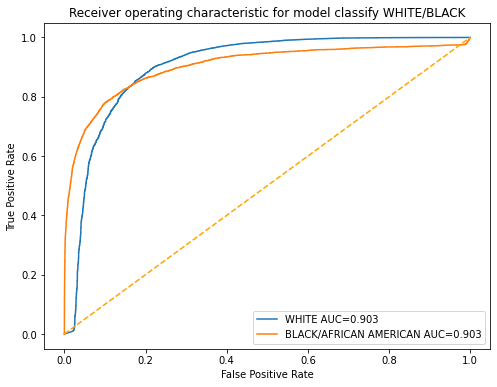

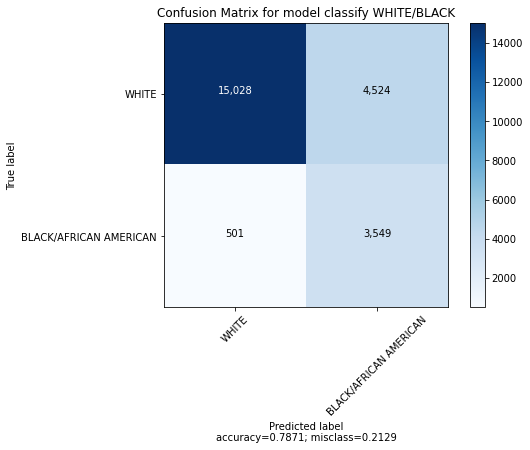

In [ ]:
target_name = ['WHITE', 'BLACK/AFRICAN AMERICAN']

cm_lr = [0 for i in range(len(target_name))]
for i in range(len(target_name)):
    cm_lr[i] = [0 for j in range(len(target_name))]

preds = model.predict(X_test)
title = 'Receiver operating characteristic for model classify WHITE/BLACK'
plot_roc(y_test, preds, title, len(target_name), target_name)
preds_ = np.round(preds)
# cf_matrix_lr = confusion_matrix(y_test, np.round(lr_preds_))
for i in range(len(y_test)):
    cm_lr[np.argmax(preds_[i])][np.argmax(y_test[i])] += 1
plot_confusion_matrix(np.array(cm_lr).transpose(), 
                      normalize = False,
                      target_names = target_name,
                      title = "Confusion Matrix for model classify WHITE/BLACK")

In [ ]:
def get_test_data(target): 
    X_test = []
    y_test = []
    tf_list = [1, 11, 19]
  
    for i in tf_list:
        filename = '/content/TFrecords/mimic-tf-record{i}.tfrecords'.format(i=i)
        raw_dataset = tf.data.TFRecordDataset(filename)
        for raw_record in raw_dataset:
            sub_y = []

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy()) 

            ethnicity = example.features.feature['ethnicity'].int64_list.value[0]

            if (example.features.feature['ethnicity'].int64_list.value[0] == get_ethnicity(target)):
                sub_y.append(1 if example.features.feature['Atelectasis'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Cardiomegaly'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Consolidation'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Edema'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Enlarged Cardiomediastinum'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Fracture'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Lung Lesion'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Lung Opacity'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['No Finding'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pleural Effusion'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pleural Other'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pneumonia'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pneumothorax'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Support Devices'].float_list.value[0] == 1 else 0)

                nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
                img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)

                img_np = img_np/256
                img_np = np.float16(img_np)

                y_test.append(sub_y)
                X_test.append(img_np)

                del sub_y
                del img_np

    return np.array(X_test), np.array(y_test)

In [ ]:
def test(model, X_test, y_test):
    scores = [ 0 for i in range(14)] 

    # preds, race = model.predict(X_test)
    
    preds = model.predict(X_test)

    for j in range(0, 14):
        fpr, tpr, threshold = roc_curve(y_test[:, j], preds[:, j], pos_label=1)
        roc_auc = auc(fpr, tpr)
        scores[j] = roc_auc

    return scores

In [ ]:
def test_draw_bar_plot(model, title):
    result = pd.DataFrame()

    for i in ethnicity_list:
        print('testing', i)
        X_test, y_test = get_test_data(i)
        print(i, 'has', len(X_test), 'images')
        one_result = test(model, X_test, y_test)
        one_result = np.array(one_result)
        #   print('auc scores for', i, 'are', one_result)
        result[i] = one_result

    result['diseases'] = Labels

    result_ = pd.melt(result, id_vars='diseases', var_name='ethnicity', value_name='auc')

    fig_dims = (20, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

    sns.set(style="whitegrid")
    sns.barplot(x='diseases', y='auc', hue='ethnicity', data=result_, ax=ax).set_title(title)
    sns.set(font_scale=1)

    h, l = ax.get_legend_handles_labels()
    counts = {'WHITE':19552, 'BLACK/AFRICAN AMERICAN':4050, 'HISPANIC/LATINO':1288, 'ASIAN':1422}
    l = [f'{yn} (n={c})' for yn,c in counts.items()]
    ax.legend(h,l, bbox_to_anchor=(0.35, 1), loc=2, borderaxespad=0.)

    filename = '/content/gdrive/MyDrive/Racial_project_result/' + title + '.png'
    plt.savefig(filename)

## testing ethnicities classifier

In [ ]:
import numpy as np
 
 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
 
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
 
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
 
    title:        the text to display at the top of the matrix
 
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
 
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
 
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
 
    """
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
    file_name = '/content/gdrive/MyDrive/Racial_project_result/' + title + '.png'
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    # plt.savefig(file_name)
    plt.show()

In [ ]:
def plot_roc(y_test, preds, title, num, list_):
    fig = plt.figure(figsize=(8,6))

    for i in range(num):
        fpr, tpr, _ = roc_curve(y_test[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        # plot the roc curve for the model
        plt.plot(fpr, tpr, linestyle='solid', label='{} AUC={:.3f}'.format(list_[i], roc_auc))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    file_name = '/content/gdrive/MyDrive/Racial_project_result/' + title+ '.png'
    # plt.savefig(file_name)
    plt.show()